**PART 1 : Building and Understanding GANs from Scratch**
1. Training a GAN on Sine Wave Data

In [ ]:
# -------------------------------------------
# 1. Import Required Libraries
# -------------------------------------------
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

# -------------------------------------------
# 2. Set Seed for Reproducibility
# -------------------------------------------
torch.manual_seed(42)


In [ ]:
# Generate training data
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))  # 1024 rows, 2 columns

# First column: random x-values between 0 and 2π
train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)

# Second column: sin(x)
train_data[:, 1] = torch.sin(train_data[:, 0])

# Labels (not used in GAN, but needed for DataLoader compatibility)
train_labels = torch.zeros(train_data_length)

# Create training set as list of (x, label) tuples
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]


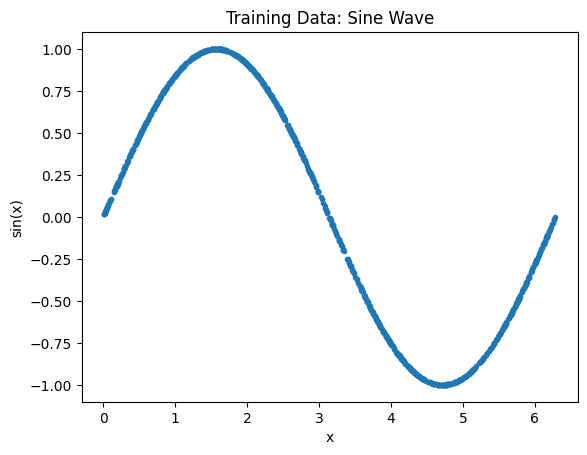

In [ ]:
# Plot the sine-wave data
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.title("Training Data: Sine Wave")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.show()


In [ ]:

# -------------------------------------------
# 4. Define DataLoader
# ------------------------------------------
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)


In [ ]:
# -------------------------------------------
# 5. Define Discriminator Network
# -------------------------------------------

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),             # Activation function
            nn.Dropout(0.3),       # Dropout to reduce overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()           # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

# Create an instance of the Discriminator
discriminator = Discriminator()


In [ ]:
# -------------------------------------------
# 6. Define Generator Network
# -------------------------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),      # Input layer
            nn.ReLU(),             # Activation
            nn.Linear(16, 32),     # Hidden layer
            nn.ReLU(),             # Activation
            nn.Linear(32, 2)       # Output layer (2D point)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()


In [ ]:

# -------------------------------------------
# 7. Set Training hyperparameters
# -------------------------------------------

lr = 0.001                  # Learning rate
num_epochs = 2000          # Number of training epochs

# Binary Cross Entropy Loss (used in GANs)
loss_function = nn.BCELoss()

# Define optimizers using Adam for both Generator and Discriminator
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)


In [ ]:
# -------------------------------------------
# 8. Training Loop
# -------------------------------------------
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):

        # Create labels
        real_samples_labels = torch.ones((batch_size, 1))                # Label 1 for real
        generated_samples_labels = torch.zeros((batch_size, 1))         # Label 0 for fake

        # Generate fake samples
        latent_space_samples = torch.randn((batch_size, 2))             # Sample random noise
        generated_samples = generator(latent_space_samples)             # Generator output

        # Combine real and fake samples and labels
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # --- Train the Discriminator ---
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # --- Train the Generator ---
        latent_space_samples = torch.randn((batch_size, 2))             # New noise for G
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator:.4f} | Loss G: {loss_generator:.4f}")


Epoch 0 | Loss D: 0.1065 | Loss G: 2.6915
Epoch 100 | Loss D: 0.6771 | Loss G: 0.7336
Epoch 200 | Loss D: 0.6455 | Loss G: 0.8836
Epoch 300 | Loss D: 0.7511 | Loss G: 0.6410
Epoch 400 | Loss D: 0.6403 | Loss G: 0.8644
Epoch 500 | Loss D: 0.6194 | Loss G: 1.0063
Epoch 600 | Loss D: 0.6766 | Loss G: 0.7339
Epoch 700 | Loss D: 0.7163 | Loss G: 0.7215
Epoch 800 | Loss D: 0.7765 | Loss G: 0.8833
Epoch 900 | Loss D: 0.5989 | Loss G: 1.0034
Epoch 1000 | Loss D: 0.6809 | Loss G: 0.6546
Epoch 1100 | Loss D: 0.6376 | Loss G: 0.8529
Epoch 1200 | Loss D: 0.6668 | Loss G: 0.6672
Epoch 1300 | Loss D: 0.6266 | Loss G: 0.9185
Epoch 1400 | Loss D: 0.6777 | Loss G: 0.7937
Epoch 1500 | Loss D: 0.6394 | Loss G: 0.8716
Epoch 1600 | Loss D: 0.6352 | Loss G: 0.7760
Epoch 1700 | Loss D: 0.7063 | Loss G: 0.8283
Epoch 1800 | Loss D: 0.6791 | Loss G: 0.7361
Epoch 1900 | Loss D: 0.6032 | Loss G: 0.8600


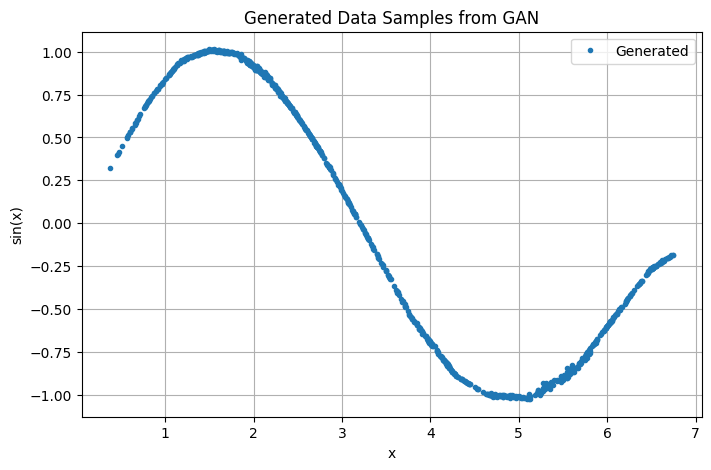

In [ ]:
# Generate 1000 new 2D random points in latent space
latent_space_samples = torch.randn(1000, 2)

# Generate fake data points from the trained Generator
generated_samples = generator(latent_space_samples)

# Convert tensor to NumPy array for plotting
generated_samples_numpy = generated_samples.detach().numpy()

# Plot the generated data
plt.figure(figsize=(8, 5))
plt.plot(generated_samples_numpy[:, 0], generated_samples_numpy[:, 1], ".", label="Generated")
plt.title("Generated Data Samples from GAN")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.legend()
plt.grid(True)
plt.show()


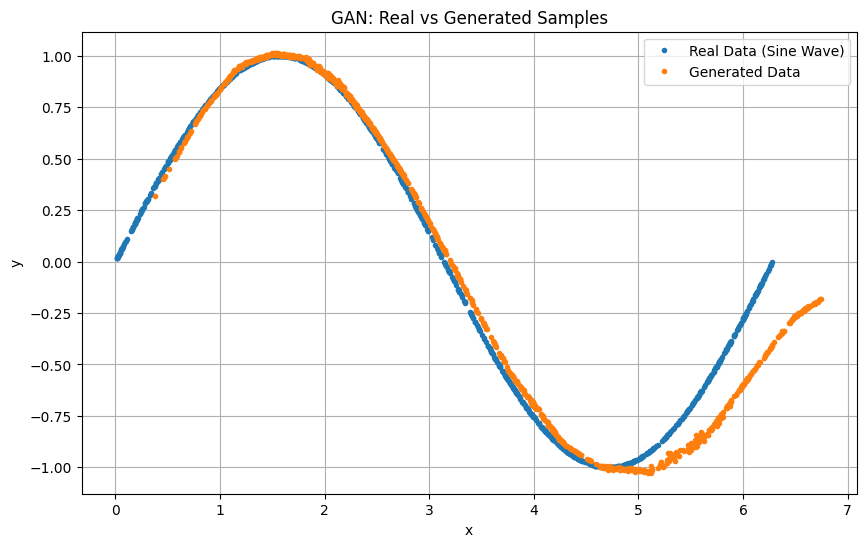

In [ ]:
# Plot original sine wave training data and generated samples together
plt.figure(figsize=(10, 6))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Real Data (Sine Wave)")
plt.plot(generated_samples_numpy[:, 0], generated_samples_numpy[:, 1], ".", label="Generated Data")
plt.title("GAN: Real vs Generated Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


**Task 2 : GAN on Noisy Parametric Curve ::   y = sin(2x) + 0.3cos(5x) + epsilon (where epsilon is a random noise term)**

In [ ]:
# -------------------------------------------
# 1. Import Required Libraries
# -------------------------------------------
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# -------------------------------------------
# 2. Set Seed for Reproducibility
# -------------------------------------------
torch.manual_seed(42)


# -------------------------------------------
# 3. Generate Noisy Parametric Training Data
# y = sin(2x) + 0.3cos(5x) + ε, where ε ~ N(0, 0.05)
# -------------------------------------------

# Number of samples
train_data_length = 1024

# Generate x values uniformly from 0 to 2π
x = 2 * math.pi * torch.rand(train_data_length)

# Generate y values using the noisy parametric equation
noise = 0.05 * torch.randn(train_data_length)
y = torch.sin(2 * x) + 0.3 * torch.cos(5 * x) + noise

# Combine x and y into a single tensor of shape (1024, 2)
train_data = torch.stack((x, y), dim=1)

# Labels are not needed but required by DataLoader (so use zeros)
train_labels = torch.zeros(train_data_length)

# Create the training set as expected by PyTorch
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]


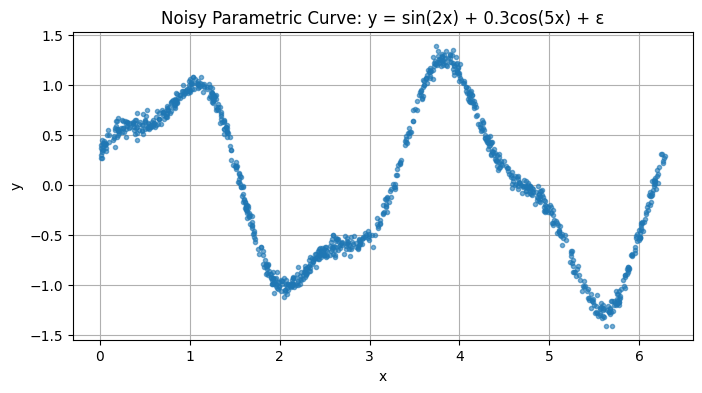

In [ ]:
# Plot the noisy curve
plt.figure(figsize=(8, 4))
plt.plot(train_data[:, 0], train_data[:, 1], ".", alpha=0.6)
plt.title("Noisy Parametric Curve: y = sin(2x) + 0.3cos(5x) + ε")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [ ]:

# -------------------------------------------
# 4. Define DataLoader
# ------------------------------------------

batch_size = 32

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)


In [ ]:
# -------------------------------------------
# 5. Define Discriminator Network
# -------------------------------------------

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator()


In [ ]:
# -------------------------------------------
# 6. Define Generator Network
# -------------------------------------------


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()


In [ ]:

# -------------------------------------------
# 7. Set Training Parameters
# -------------------------------------------


# Hyperparameters
num_epochs = 2000
learning_rate = 0.001
batch_size = 32  # already used in DataLoader

# Binary Cross-Entropy Loss
loss_function = nn.BCELoss()

# Optimizers for both networks
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)


In [ ]:
# -------------------------------------------
# 8. Training Loop
# ------------------------------------------


for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # real samples and labels
        real_samples = real_samples
        real_labels = torch.ones((batch_size, 1))

        # Fake samples and labels
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        fake_labels = torch.zeros((batch_size, 1))

        # Combine real and fake data
        all_samples = torch.cat((real_samples, generated_samples.detach()))
        all_labels = torch.cat((real_labels, fake_labels))

        # Train Discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Train Generator
        generator.zero_grad()
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # Print losses every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator:.4f} | Loss G: {loss_generator:.4f}")


Epoch 0 | Loss D: 0.1810 | Loss G: 2.3275
Epoch 100 | Loss D: 0.6970 | Loss G: 0.7555
Epoch 200 | Loss D: 0.6737 | Loss G: 0.7274
Epoch 300 | Loss D: 0.6435 | Loss G: 0.8107
Epoch 400 | Loss D: 0.6542 | Loss G: 0.8047
Epoch 500 | Loss D: 0.5905 | Loss G: 0.8588
Epoch 600 | Loss D: 0.6828 | Loss G: 0.7692
Epoch 700 | Loss D: 0.6741 | Loss G: 0.7204
Epoch 800 | Loss D: 0.6738 | Loss G: 0.7723
Epoch 900 | Loss D: 0.6686 | Loss G: 0.7947
Epoch 1000 | Loss D: 0.6783 | Loss G: 0.7552
Epoch 1100 | Loss D: 0.6546 | Loss G: 0.7419
Epoch 1200 | Loss D: 0.6984 | Loss G: 0.7918
Epoch 1300 | Loss D: 0.6848 | Loss G: 0.7490
Epoch 1400 | Loss D: 0.6648 | Loss G: 0.7038
Epoch 1500 | Loss D: 0.7143 | Loss G: 0.7549
Epoch 1600 | Loss D: 0.6982 | Loss G: 0.7166
Epoch 1700 | Loss D: 0.7086 | Loss G: 0.8767
Epoch 1800 | Loss D: 0.6511 | Loss G: 0.7773
Epoch 1900 | Loss D: 0.7128 | Loss G: 0.7517


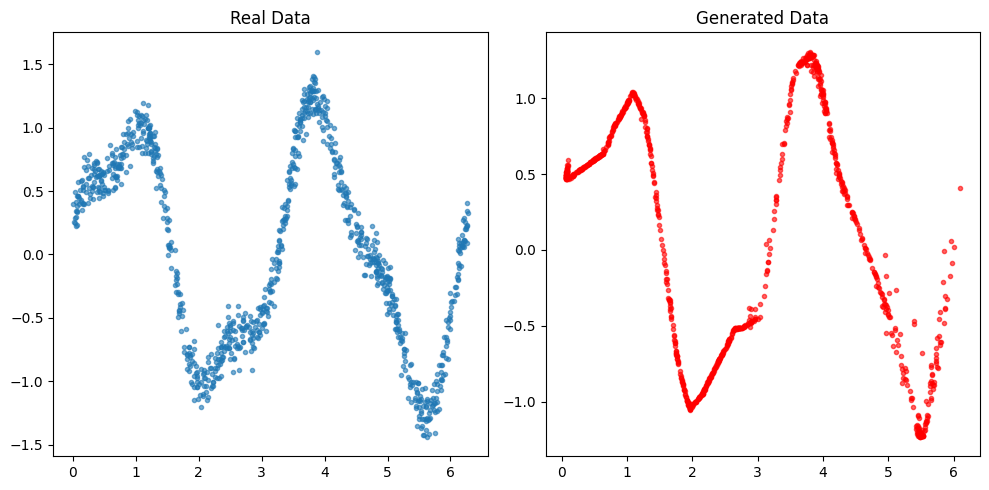

In [ ]:
# -------------------------------------------
# 9. Generate and Compare Real vs Fake Samples
# -------------------------------------------
# Generate 1000 new latent samples

latent_space_samples = torch.randn(1000, 2)
generated_samples = generator(latent_space_samples).detach().numpy()

# Prepare real data (same generation logic used for training)
# Generate real test samples with ε ~ N(0, 0.1)
import numpy as np
x_vals = 2 * np.pi * np.random.rand(1000)
epsilon = 0.1 * np.random.randn(1000) # TEST noise slightly larger
y_vals = np.sin(2 * x_vals) + 0.3 * np.cos(5 * x_vals) + epsilon
real_data = np.stack((x_vals, y_vals), axis=1)

# -------------------------------------------
# 10. Plot Comparison of Real vs Generated Data
# -------------------------------------------

# Plot real vs generated
plt.figure(figsize=(10, 5))

# Real data (blue)
plt.subplot(1, 2, 1)
plt.title("Real Data")
plt.plot(real_data[:, 0], real_data[:, 1], '.', alpha=0.6)

# Generated data (red)
plt.subplot(1, 2, 2)
plt.title("Generated Data")
plt.plot(generated_samples[:, 0], generated_samples[:, 1], '.', alpha=0.6, color='r')

plt.tight_layout()
plt.show()


**Task 3: Architectural Modifications and Performance Improvements**

In [ ]:
# --------------------------------------------------------
# STEP 1: Modified Generator – LeakyReLU + Dropout
# --------------------------------------------------------
import torch.nn.functional as F
import torch.nn as nn

class ModifiedGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),   # First hidden layer
            nn.LeakyReLU(0.2),  # Replace ReLU with LeakyReLU
            nn.Dropout(0.2),    # Add dropout for regularization
            nn.Linear(32, 64),  # Second hidden layer
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 2)    # Output layer (2D point)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the new generator
generator = ModifiedGenerator()


In [ ]:
# --------------------------------------------------------
# Shared Training Components
# --------------------------------------------------------
# Discriminator remains unchanged (same as previous tasks)
discriminator = Discriminator()

# Loss and optimizers
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)


In [ ]:
# --------------------------------------------------------
# Training Loop – for LeakyReLU + Dropout Generator
# --------------------------------------------------------

num_epochs = 2000
batch_size = 32
print_epoch_num = 100 # Print loss every 100 epochs


for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # REAL and FAKE samples for Discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Train Discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Train Generator
        latent_space_samples = torch.randn((batch_size, 2))
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    if epoch % print_epoch_num == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator:.4f} | Loss G: {loss_generator:.4f}")


Epoch 0 | Loss D: 0.4309 | Loss G: 1.6642
Epoch 100 | Loss D: 0.5201 | Loss G: 1.0460
Epoch 200 | Loss D: 0.4310 | Loss G: 1.2135
Epoch 300 | Loss D: 0.4811 | Loss G: 1.4938
Epoch 400 | Loss D: 0.4963 | Loss G: 1.5091
Epoch 500 | Loss D: 0.3715 | Loss G: 1.4299
Epoch 600 | Loss D: 0.3487 | Loss G: 2.1732
Epoch 700 | Loss D: 0.4051 | Loss G: 1.6437
Epoch 800 | Loss D: 0.4717 | Loss G: 1.8111
Epoch 900 | Loss D: 0.5543 | Loss G: 2.1303
Epoch 1000 | Loss D: 0.3336 | Loss G: 1.9233
Epoch 1100 | Loss D: 0.3638 | Loss G: 2.0146
Epoch 1200 | Loss D: 0.3200 | Loss G: 2.0934
Epoch 1300 | Loss D: 0.3892 | Loss G: 2.3315
Epoch 1400 | Loss D: 0.3982 | Loss G: 1.6861
Epoch 1500 | Loss D: 0.3150 | Loss G: 1.8730
Epoch 1600 | Loss D: 0.3972 | Loss G: 1.6334
Epoch 1700 | Loss D: 0.3977 | Loss G: 2.5570
Epoch 1800 | Loss D: 0.4854 | Loss G: 1.8617
Epoch 1900 | Loss D: 0.4136 | Loss G: 2.0306


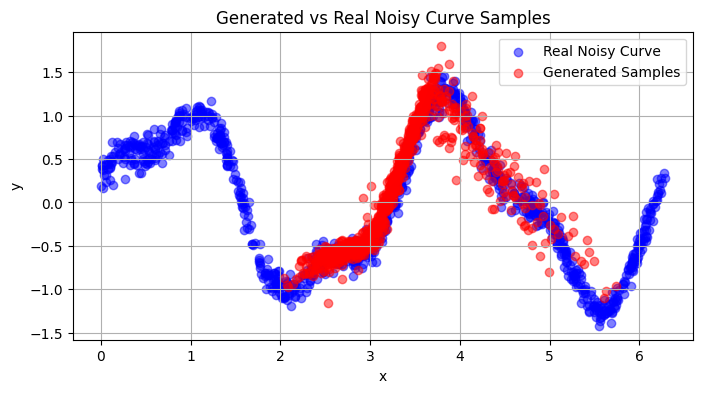

In [ ]:

# Generate 1000 samples from latent space
latent_samples = torch.randn(1000, 2)
generated_samples = generator(latent_samples).detach().numpy()

# Generate the real noisy parametric curve
x_real = 2.0 * math.pi * torch.rand(1000)
y_real = torch.sin(2 * x_real) + 0.3 * torch.cos(5 * x_real) + 0.1 * torch.randn(1000)
real_samples = torch.stack((x_real, y_real), dim=1).numpy()

# Plot real vs generated
plt.figure(figsize=(8, 4))
plt.scatter(real_samples[:, 0], real_samples[:, 1], color='blue', alpha=0.5, label="Real Noisy Curve")
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='red', alpha=0.5, label="Generated Samples")
plt.legend()
plt.title("Generated vs Real Noisy Curve Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [ ]:
# --------------------------------------------------------
# STEP 2: Generator with Batch Normalization + Dropout
# --------------------------------------------------------

import torch.nn.functional as F

class GeneratorWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.BatchNorm1d(32), # Normalize output before activation
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# Replace previous generator with this version
generator = GeneratorWithBatchNorm()


In [ ]:
# --------------------------------------------------------
# Shared Training Components
# --------------------------------------------------------
# Discriminator remains unchanged (same as previous tasks)
discriminator = Discriminator()


# Loss and optimizers
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)


In [ ]:
# --------------------------------------------------------
# Training Loop – for Batch Normalization + Dropout
# --------------------------------------------------------
num_epochs = 2000
batch_size = 32
print_epoch_num = 100

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # REAL and FAKE samples for Discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Train Discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Train Generator
        latent_space_samples = torch.randn((batch_size, 2))
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    if epoch % print_epoch_num == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator:.4f} | Loss G: {loss_generator:.4f}")


Epoch 0 | Loss D: 0.5016 | Loss G: 1.9431
Epoch 100 | Loss D: 0.4367 | Loss G: 1.1940
Epoch 200 | Loss D: 0.4152 | Loss G: 1.5424
Epoch 300 | Loss D: 0.3009 | Loss G: 3.3409
Epoch 400 | Loss D: 0.3148 | Loss G: 2.1285
Epoch 500 | Loss D: 0.4738 | Loss G: 2.0579
Epoch 600 | Loss D: 0.3707 | Loss G: 2.5770
Epoch 700 | Loss D: 0.3168 | Loss G: 2.1125
Epoch 800 | Loss D: 0.3183 | Loss G: 2.4727
Epoch 900 | Loss D: 0.4127 | Loss G: 1.6281
Epoch 1000 | Loss D: 0.3233 | Loss G: 2.1889
Epoch 1100 | Loss D: 0.2603 | Loss G: 1.4167
Epoch 1200 | Loss D: 0.3908 | Loss G: 1.7941
Epoch 1300 | Loss D: 0.4336 | Loss G: 1.5125
Epoch 1400 | Loss D: 0.2631 | Loss G: 1.6709
Epoch 1500 | Loss D: 0.2927 | Loss G: 1.5248
Epoch 1600 | Loss D: 0.3092 | Loss G: 1.7437
Epoch 1700 | Loss D: 0.4225 | Loss G: 1.6452
Epoch 1800 | Loss D: 0.2927 | Loss G: 1.6641
Epoch 1900 | Loss D: 0.3650 | Loss G: 1.5822


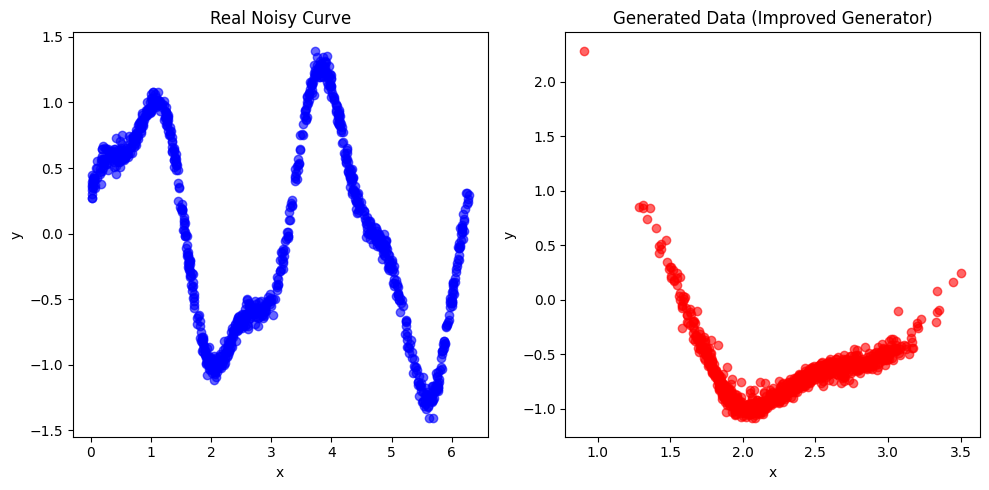

In [ ]:
# Sample from latent space
latent_space_samples = torch.randn(1000, 2)
generated_samples = generator(latent_space_samples).detach().numpy()

# Plot real vs generated
plt.figure(figsize=(10, 5))

# Real data
plt.subplot(1, 2, 1)
plt.title("Real Noisy Curve")
plt.scatter(train_data[:, 0], train_data[:, 1], color='blue', alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")

# Generated data
plt.subplot(1, 2, 2)
plt.title("Generated Data (Improved Generator)")
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='red', alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()


In [ ]:

# --------------------------------------------------------
# STEP 3: Modified Generator with Latent Dim = 3 and One Dropout Removed
# --------------------------------------------------------
import torch
import torch.nn as nn

class ModifiedGeneratorV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 32),               # Input dim changed from 2 to 3
            nn.LeakyReLU(0.2),              # Better gradient flow
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),                # Keep only one dropout
            nn.Linear(64, 2)                # Output 2D point (x, y)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the new generator
generator = ModifiedGeneratorV2()


In [ ]:
# Reuse the same Discriminator definition from before
discriminator = Discriminator()

# Binary Cross Entropy Loss
loss_function = nn.BCELoss()

# Optimizers for Discriminator and Modified Generator
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)


In [ ]:
# Training Loop with Modified Generator (Latent Dim = 3)

num_epochs = 2000
batch_size = 32

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # === TRAIN DISCRIMINATOR ===
        real_samples_labels = torch.ones((batch_size, 1))  # Label 1 for real

        # Generate fake data using modified latent vector (3D)
        latent_space_samples = torch.randn((batch_size, 3))  # Latent dim = 3
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))


        # Combine real and fake samples
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Discriminator optimization step
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === TRAIN GENERATOR ===
        latent_space_samples = torch.randn((batch_size, 3))  # Latent dim = 3
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # Print losses every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator.item():.4f} | Loss G: {loss_generator.item():.4f}")


Epoch 0 | Loss D: 0.3856 | Loss G: 1.4070
Epoch 100 | Loss D: 0.5661 | Loss G: 0.9233
Epoch 200 | Loss D: 0.5825 | Loss G: 1.6631
Epoch 300 | Loss D: 0.4854 | Loss G: 1.9966
Epoch 400 | Loss D: 0.5349 | Loss G: 1.2613
Epoch 500 | Loss D: 0.3862 | Loss G: 2.1601
Epoch 600 | Loss D: 0.5278 | Loss G: 2.6037
Epoch 700 | Loss D: 0.4737 | Loss G: 1.7380
Epoch 800 | Loss D: 0.4286 | Loss G: 2.7824
Epoch 900 | Loss D: 0.5494 | Loss G: 2.4066
Epoch 1000 | Loss D: 0.4250 | Loss G: 1.5796
Epoch 1100 | Loss D: 0.4537 | Loss G: 3.0277
Epoch 1200 | Loss D: 0.3636 | Loss G: 1.6152
Epoch 1300 | Loss D: 0.4111 | Loss G: 2.6386
Epoch 1400 | Loss D: 0.4671 | Loss G: 3.1312
Epoch 1500 | Loss D: 0.3944 | Loss G: 1.9234
Epoch 1600 | Loss D: 0.3870 | Loss G: 2.4832
Epoch 1700 | Loss D: 0.6302 | Loss G: 1.8249
Epoch 1800 | Loss D: 0.4716 | Loss G: 1.8904
Epoch 1900 | Loss D: 0.3580 | Loss G: 1.5747


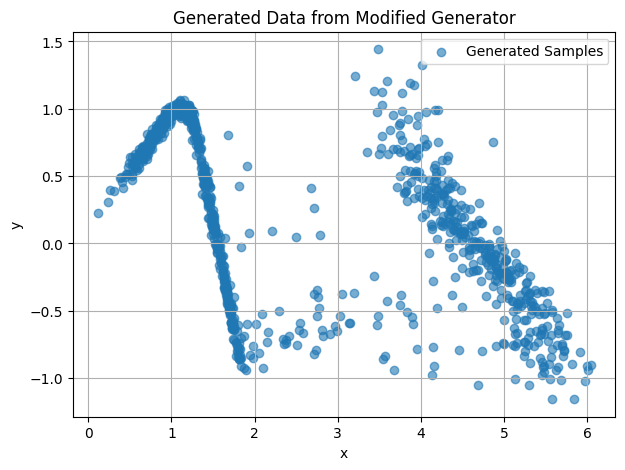

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 1000 random latent vectors (dim=3)
latent_samples = torch.randn(1000, 3)
generated = generator(latent_samples).detach().numpy()

# Plot generated data
plt.figure(figsize=(7, 5))
plt.scatter(generated[:, 0], generated[:, 1], alpha=0.6, label='Generated Samples')
plt.title("Generated Data from Modified Generator")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


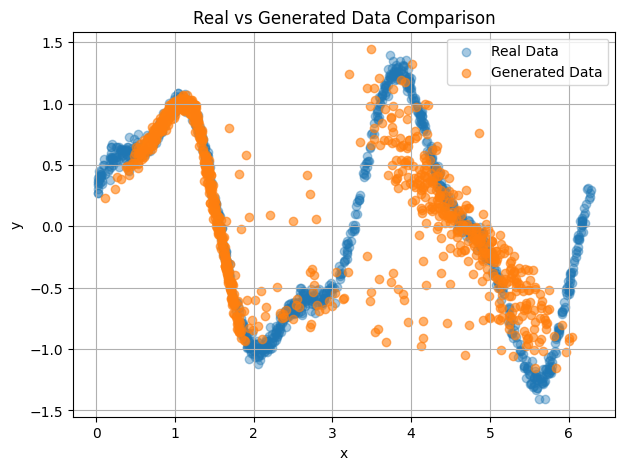

In [ ]:
# Original real data for reference
real_data_np = train_data.numpy()

# Plot real vs generated
plt.figure(figsize=(7, 5))
plt.scatter(real_data_np[:, 0], real_data_np[:, 1], alpha=0.4, label='Real Data')
plt.scatter(generated[:, 0], generated[:, 1], alpha=0.6, label='Generated Data')
plt.title("Real vs Generated Data Comparison")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
